In [1]:
import matplotlib.pyplot as plt
import imgaug
import numpy as np
import os
import pandas as pd
import time
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2
from tqdm.notebook import tqdm
from IPython.display import display, HTML
from pathlib import Path



#image augmentation:
import PIL
from PIL import Image
from imgaug import augmenters as iaa
import imgaug.augmenters as augs

In [2]:
IMAGE_SIZE = 96

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [4]:
# Set device to GPU if available.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
class BaselineTokenCNN(nn.Module):
    def __init__(self, num_classes):
        super(BaselineTokenCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=7)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 9 * 9, 600)
        self.fc2 = nn.Linear(600, 200)
        self.fc3 = nn.Linear(200, num_classes)
        
    def forward(self, x):
        x = x.float()
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, 16 * 9 * 9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Identifying Expressions

In [6]:
import cv2

class ExpressionImageDataset(Dataset):
    """
    An expression-level dataset.
    """
    def __init__(self, pickle_file, transform=None):
        """
        Args:
            pickle_file (string): Path to dataset pickle file.
            transform (callable, optional): Optional transform to be applied
                    on a sample.
        """
        with open(pickle_file, 'rb') as f:
            self.df_data = pd.DataFrame(pickle.load(f))
            
#         print(self.df_data)

        self.transform = transform
    
    def __len__(self):
        return len(self.df_data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        row = self.df_data.iloc[idx]
                
        traces_data = row['traces_data']
        img_path = row['img_path']
        tokens = row['tokens']
        latex = row['latex']
        
        # CV2 will read the image with white being 255 and black being 0, but since
        # our token-level training set uses binary arrays to represent images, we
        # need to binarize our image here as well.
        image_raw = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image_binarized = cv2.threshold(image_raw, 127, 255, cv2.THRESH_BINARY)[1]
        image_bitmap = image_binarized / 255.0
        
        sample = {
            'image': image_binarized,
            'image_bitmap': image_bitmap,
            'traces_data': traces_data,
            'tokens': tokens,
            'latex': latex
        }
        
        if self.transform:
            sample = self.transform(sample)

        return sample

In [7]:
train_exp_path = os.path.join(os.getcwd(), 'data', 'train=2011,2013_test=2012', 'train', 'train.pickle')
test_exp_path = os.path.join(os.getcwd(), 'data', 'train=2011,2013_test=2012', 'test', 'test.pickle')

# print('train')
train_exp_set = ExpressionImageDataset(train_exp_path)
# print('test')
test_exp_set = ExpressionImageDataset(test_exp_path)

In [8]:
def image_to_components(img):
    """
    Identifies the connected components (groups of black pixels) within an image.
    Returns a list of tuples. The first element of each tuple is the component
    image, and the second element is a tuple representing the bounding box of the
    component (relative to the original image dimensions).
    """
    
    # Invert the image because for CV2, foreground objects should be white, and the background black.
    img_flipped = cv2.bitwise_not(img)

    # cv2.connectedComponents returns a mask of the input where each element is a number from 0
    # to num_labels. All the 0's are considered the same component, 1's together, so on and
    # so forth.
    num_labels, labeled_img = cv2.connectedComponents(img_flipped)

    components = []

    # Skip the first component because it will be the background.
    for l in range(1, num_labels):
        mask = np.zeros(labeled_img.shape, dtype=np.uint8)
        mask[labeled_img == l] = 255

        rect = cv2.boundingRect(mask)

    #     # Draw bounding box to make sure it's correct.
    #     cv2.rectangle(mask, (x, y), (x + w, y + h), (36,255,12), 2)

        mask = cv2.bitwise_not(mask)

        components.append((mask, rect))

    components.sort(key=lambda c: (c[1][0], c[1][1]))

#     for mask, rect in components:    
#         plt.imshow(mask, cmap='gray')
#         plt.show()
        
    return components

In [9]:
def process_component(image, bounding_rect):
    """
    Processes a component image so it can be fed into the CNN for as input.
    It crops the component, pads the cropped image so that it's square, and
    then resizes it to the shape the CNN expects.
    
    Args:
        image - Image containing a single component.
        bounding_rect - Tuple defining the bounding box of the component.
    """
    
    x, y, w, h = bounding_rect
    
    # Crop the image to just the bounding box.
    image = image[y: y + h, x: x + w]
    
    # Pad the image so it's square.
    if w > h:
        pad = int((w - h) / 2)        
        image = cv2.copyMakeBorder(image, 
                                   top=pad, 
                                   bottom=pad, 
                                   left=0, 
                                   right=0, 
                                   borderType=cv2.BORDER_CONSTANT, 
                                   value=255)
    else:
        pad = int((h - w) / 2)
        image = cv2.copyMakeBorder(image, 
                                   top=0, 
                                   bottom=0, 
                                   left=pad, 
                                   right=pad, 
                                   borderType=cv2.BORDER_CONSTANT, 
                                   value=255)
    
    # Scale down to the correct size. Seems like cv2.INTER_AREA is the best
    # interpolation method for maintaining stroke wdith.
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)
    
    # During the resize some pixels will get scaled to be between 0 (black) and 255 (white).
    # In order to maintain stroke width, we set all non-white pixels to full black.
    # If we don't do this the resulting image ends up looking rather sparse.
    # We also convert the image to binary so that it's ready for the model.
    image = (image == 255).astype(int)
    
    return image

(322, 483)


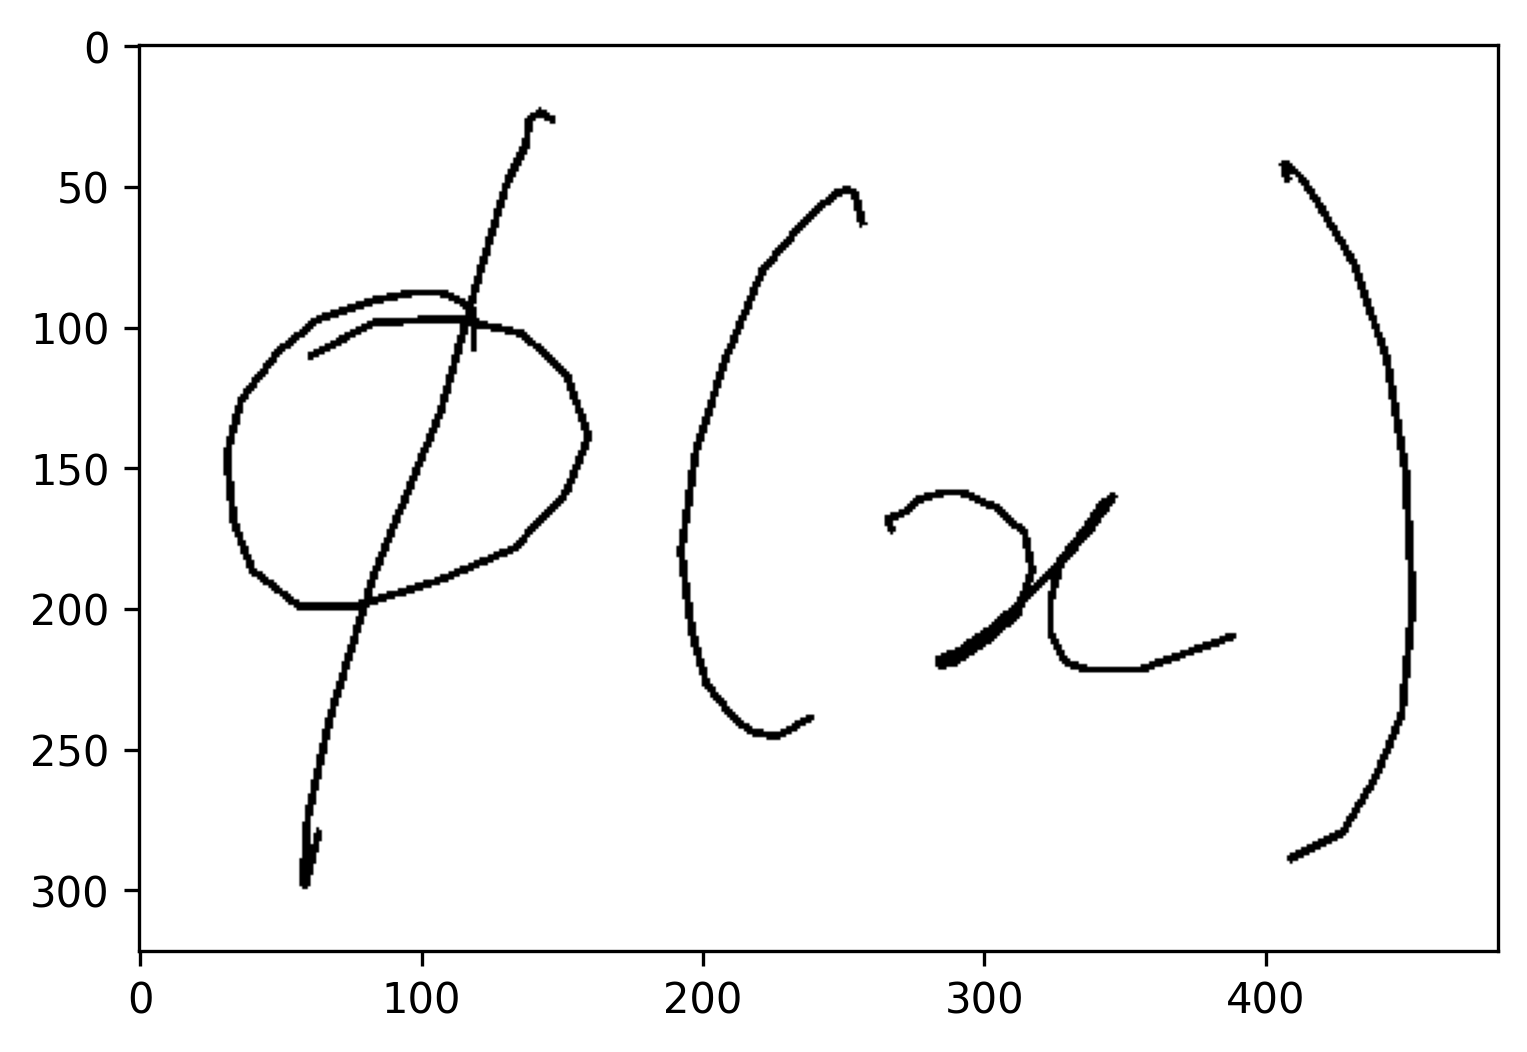

(30, 22, 131, 278)


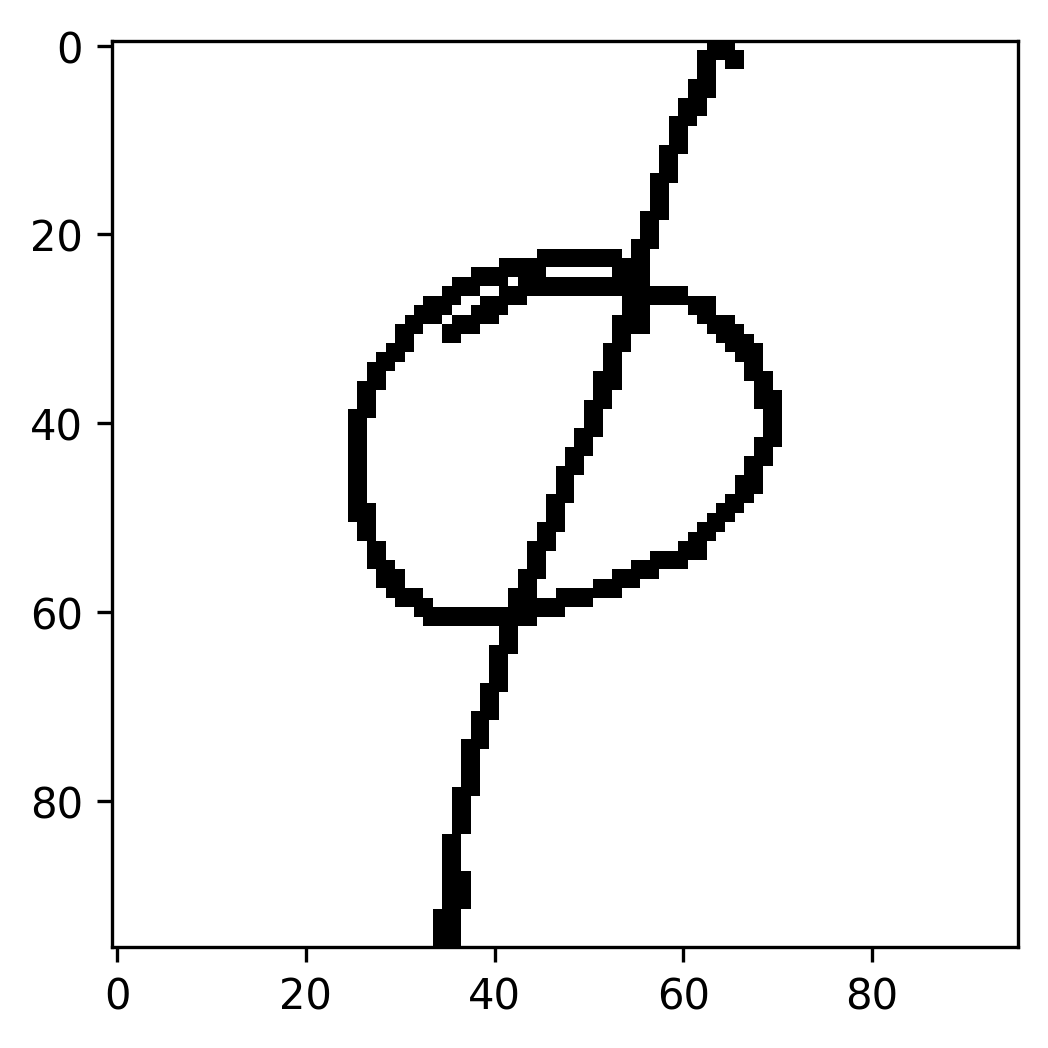

(191, 50, 68, 197)


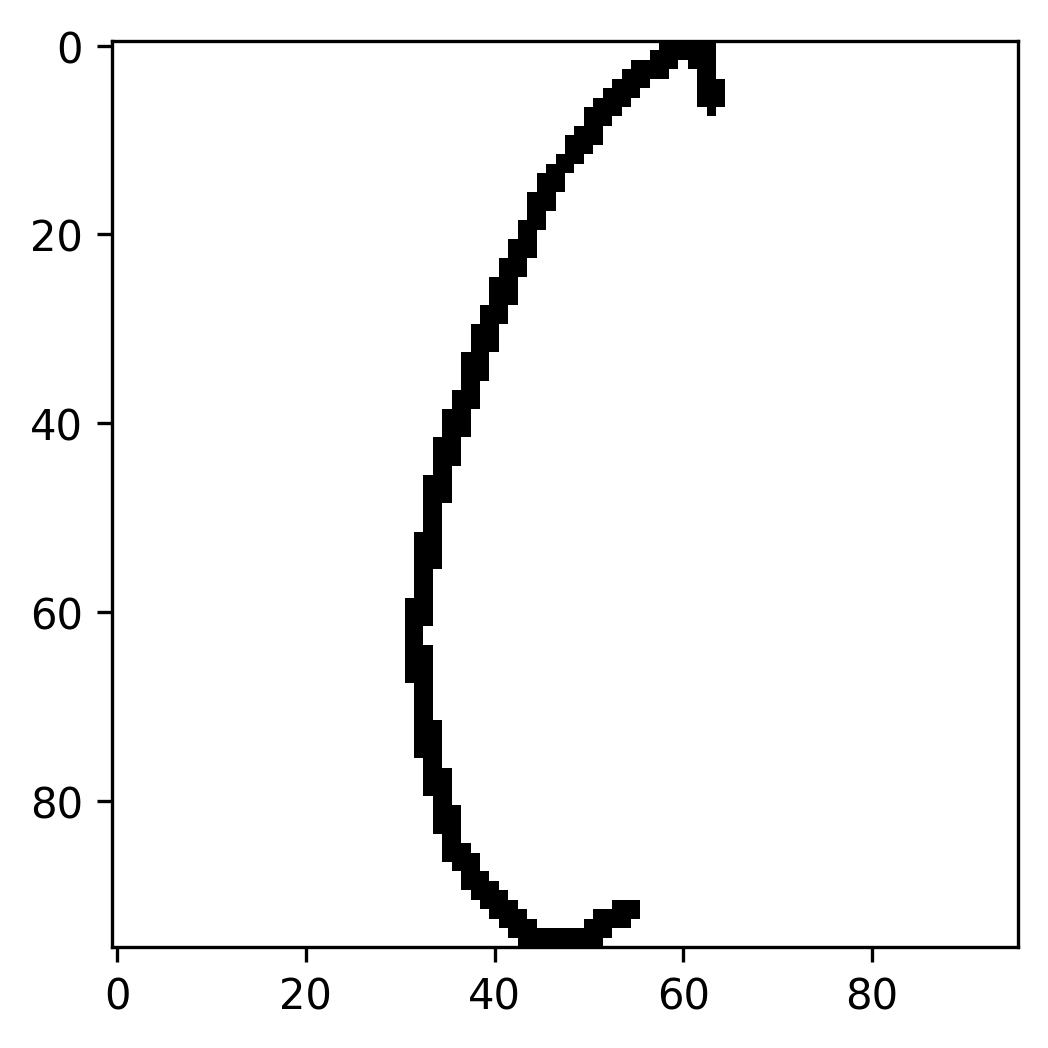

(265, 158, 125, 65)


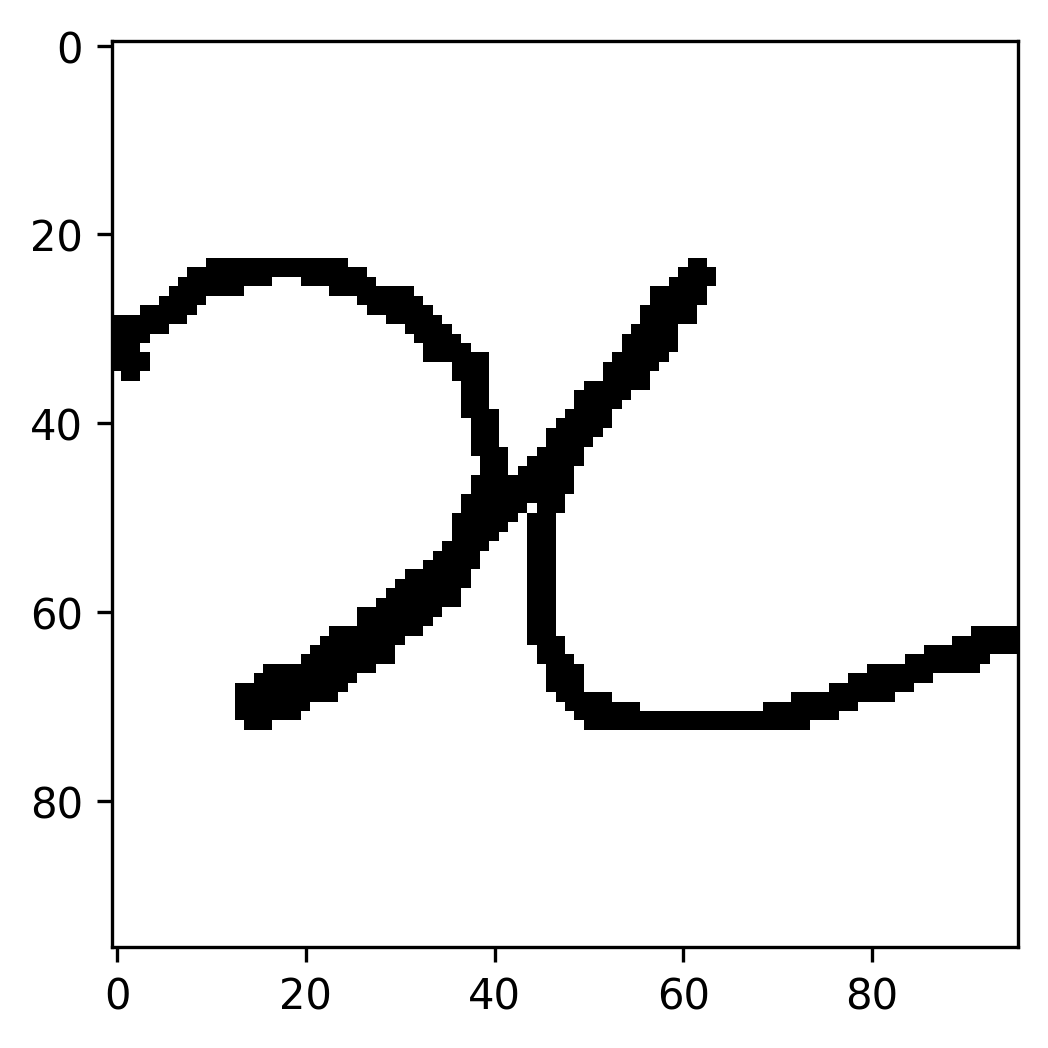

(405, 41, 49, 250)


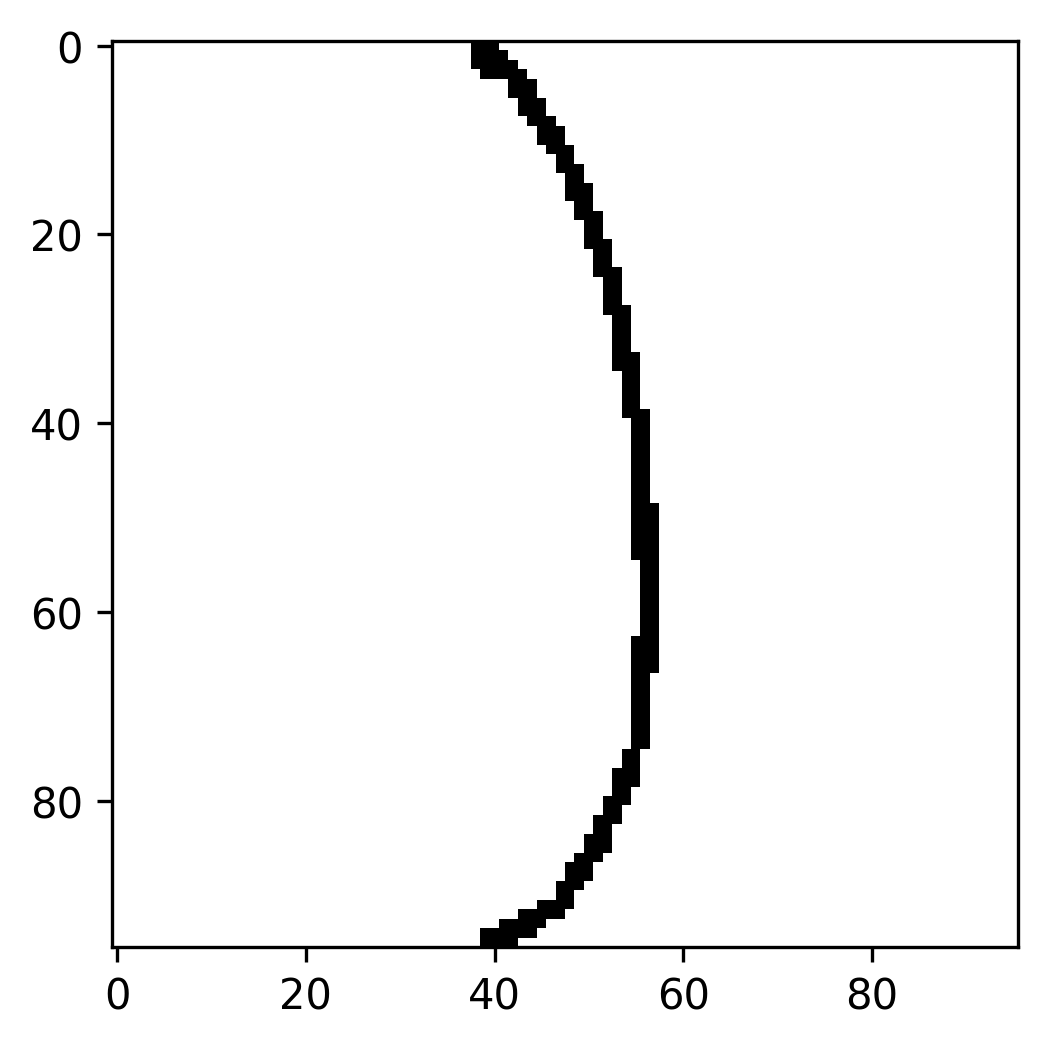

In [10]:
# Example code.
test_img = train_exp_set[0]['image']

print(test_img.shape)
plt.imshow(test_img, cmap='gray')
plt.show()

components = image_to_components(test_img)

for img, rect in components:
    print(rect)
    
    out = process_component(img, rect)
    plt.imshow(out, cmap='gray')
    plt.show()

# Testing Expression-Level Detection

(216, 1100)
[(50, 60, 6, 87), (75, 76, 57, 82), (192, 63, 9, 98), (465, 66, 11, 100), (514, 72, 44, 88), (590, 74, 48, 79), (877, 57, 49, 97), (967, 50, 82, 84), (281, 60, 92, 103), (690, 64, 115, 97)]


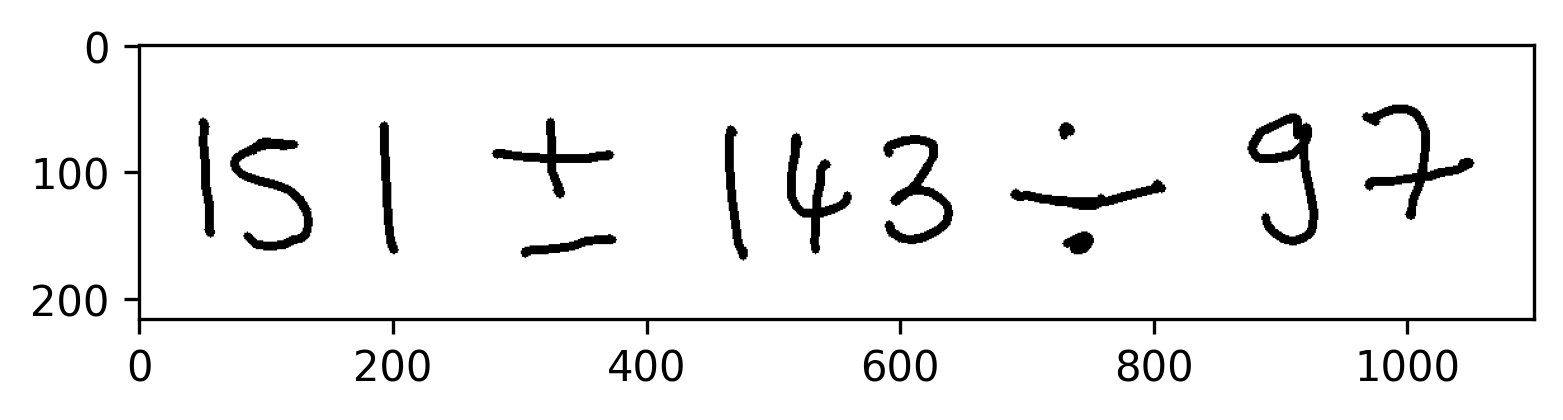

In [11]:
test_traces_data = train_exp_set[2]['traces_data']

def get_traces_data_stats(traces_data):
    all_coords = []
    for pattern in traces_data:
        for trace in pattern['trace_group']:
            all_coords.extend(trace)
        
    all_coords = np.array(all_coords)
    
    x_min, y_min = np.min(all_coords, axis=0)
    width, height = np.max(all_coords, axis=0) - [x_min, y_min] + 1
    
    return x_min, y_min, width, height

def get_trace_group_bounding_box(trace_group):
    all_coords = []
    for t in trace_group:
        all_coords.extend(t)
        
    all_coords = np.array(all_coords)
    
    x_min, y_min = np.min(all_coords, axis=0)
    width, height = np.max(all_coords, axis=0) - [x_min, y_min] + 1
    
    return x_min, y_min, width, height
    

def draw_traces_data(traces_data):
    im_x_min, im_y_min, width, height = get_traces_data_stats(traces_data)
    
    # Scale the image down.
    max_dim = 1000 # Maximum dimension pre-pad.
    sf = 1000 / max(height, width)
    scaled_height = int(height * sf)
    scaled_width = int(width * sf)
    
    image = np.ones((scaled_height, scaled_width))
    
    # Pad the scaled image. We pad the image first before we draw the traces, because it's possible that
    # for certain stroke widths, part of the expression would be cut off. Adding (enough) padding before 
    # drawing prevents this issue.
    pad_factor = 0.05
    pad_amount = int(max(pad_factor * scaled_width, pad_factor * scaled_height))
    pad_width = ((pad_amount, pad_amount), (pad_amount, pad_amount))
    image = np.pad(image, 
                     pad_width=pad_amount, 
                     mode='constant', 
                     constant_values=1)
        
    # Draw the traces on the scaled/padded image.
    for pattern in traces_data:
        for trace in pattern['trace_group']:
            trace = np.array(trace)
            trace -= np.array([im_x_min, im_y_min])
            trace = (trace.astype(np.float64) * sf).astype(int)
            trace += int(pad_factor * scaled_width)
            
            for coord_idx in range(1, len(trace)):
                cv2.line(image, tuple(trace[coord_idx - 1]), tuple(trace[coord_idx]), color=(0), thickness=5)
    
    # Binarize.
    image = (image > 0).astype(int) 
    
    # Open CV wants images to be between 0 and 255.
    image *= 255
    image = image.astype(np.uint8)
    
    boxes = []
    
    # Get bounding boxes.
    for pattern in traces_data:
        trace_group = pattern['trace_group']
        rect_x_min, rect_y_min, rect_width, rect_height = get_trace_group_bounding_box(trace_group)
        
        rect_x_min = (rect_x_min - im_x_min) * sf + pad_width[1][0]
        rect_y_min = (rect_y_min - im_y_min) * sf + pad_width[0][0]
        
        rect_width *= sf
        rect_height *= sf
        
        # Convert bounding box coords to integers.
        rect_x_min = int(rect_x_min)
        rect_y_min = int(rect_y_min)
        rect_width = int(rect_width)
        rect_height = int(rect_height)
              
        # Draw the rectangle.
#         image = cv2.rectangle(image, 
#                               (int(rect_x_min), int(rect_y_min)), 
#                               (int(rect_x_min + rect_width), int(rect_y_min + rect_height)), 
#                               (0), 
#                               5)
        
        boxes.append((rect_x_min, rect_y_min, rect_width, rect_height))
    
#     plt.imshow(image, cmap='gray')
#     plt.show()
    
    return image, boxes
    
image, boxes = draw_traces_data(test_traces_data)
plt.imshow(image, cmap='gray')
print(image.shape)
print(boxes)

In [12]:
def intersect_area(rect1, rect2):
    """
    rect1 and rect2 are tuples of the form (x, y, width, height).
    """
    r1_x_min, r1_y_min, r1_width, r1_height = rect1
    r2_x_min, r2_y_min, r2_width, r2_height = rect2
    
    dx = min(r1_x_min + r1_width, r2_x_min + r2_width) - max(r1_x_min, r2_x_min)
    dy = min(r1_y_min + r1_height, r2_y_min + r2_height) - max(r1_y_min, r2_y_min)
    if (dx>=0) and (dy>=0):
        return dx*dy
    
    return 0
    
def get_iou(rect1, rect2):
    rect1_area = rect1[2] * rect1[3]
    rect2_area = rect2[2] * rect2[3]
    
    intersect = intersect_area(rect1, rect2)
    union = rect1_area + rect2_area - intersect
    
    return intersect / union

In [13]:
def invert(img):
    return ~img

def segmentation_erosion(img, k=5):
    kernel = np.ones((k,k),np.uint8)
    
    img = invert(img)
    img = cv2.erode(img, kernel, iterations = 1)
    img = invert(img)
    
    return img

def segmentation_dilation(img, k=5):    
    kernel = np.ones((k,k),np.uint8)
    
    img = invert(img)
    img = cv2.dilate(img, kernel, iterations = 1)
    img = invert(img)
    
    return img

def segmentation_opening(img, k=5):
    kernel = np.ones((k,k),np.uint8)
    
    img = invert(img)
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    img = invert(img)
    
    return img

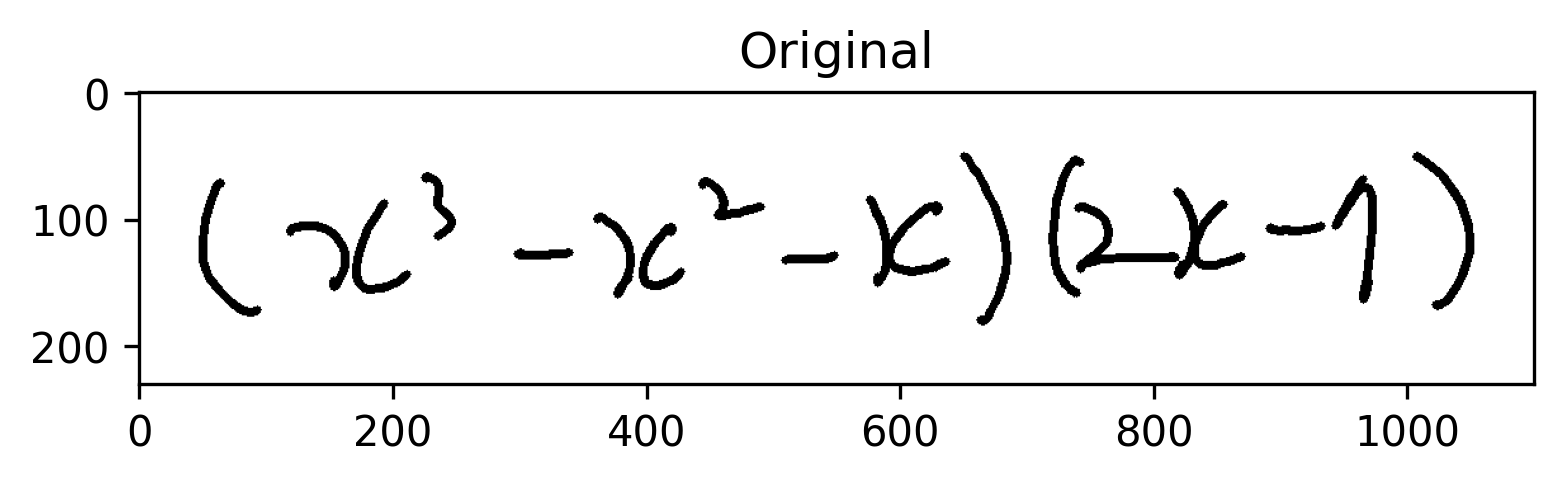

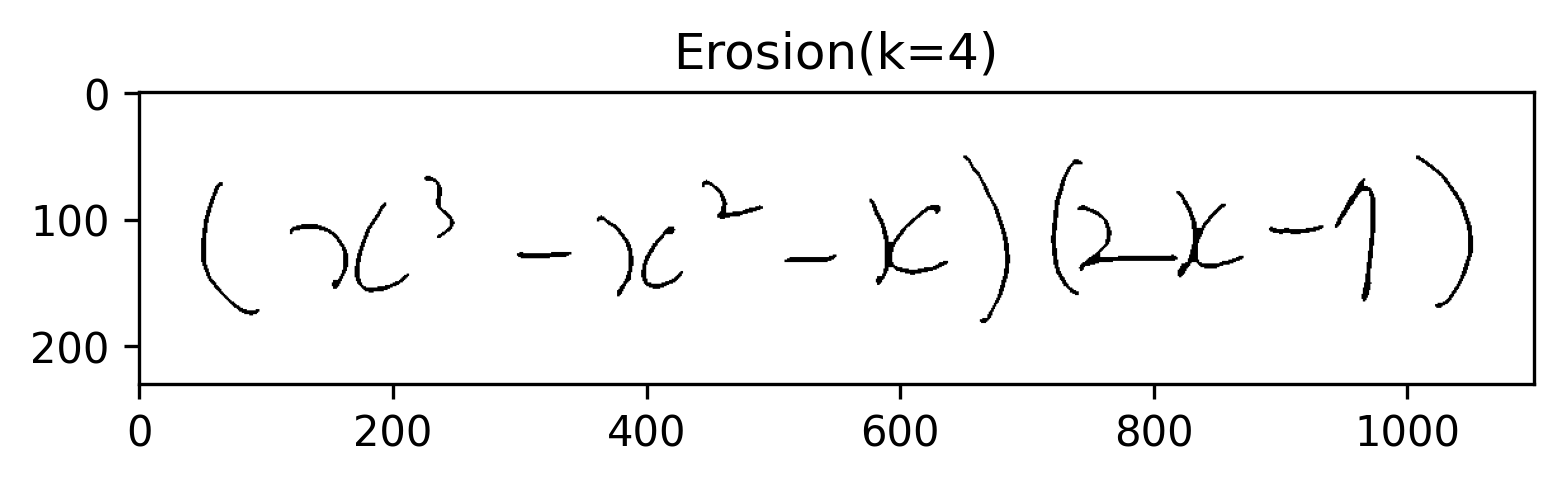

In [31]:
img, _ = draw_traces_data(test_exp_set[10]['traces_data'])

k = 4

plt.imshow(img, cmap='gray')
plt.title('Original')
plt.show()

plt.imshow(segmentation_erosion(img, k=k), cmap='gray')
plt.title(f'Erosion(k={k})')
plt.show()

# plt.imshow(segmentation_dilation(img, k=k), cmap='gray')
# plt.title(f'Dilation(k={k})')
# plt.show()

# plt.imshow(segmentation_opening(img, k=k), cmap='gray')
# plt.title(f'Opening(k={k})')
# plt.show()

In [19]:
from collections import defaultdict

def evaluate(model, classes, morph_transform=None):
    num_exp_correct = 0
    num_tokens_wrong_dict = {}

    all_precision = defaultdict(list)
    all_recall = defaultdict(list)
    
    correct_per_token = defaultdict(lambda: defaultdict(int))
    total_per_token = defaultdict(lambda: defaultdict(int))

    # We evaluate on test_exp_set, which is generated only using data from 2012. This is to avoid data leakage
    # with the token-level training set, which is generated on data from 2011 and 2013.
    for data in tqdm(test_exp_set, leave=False):
        image, true_boxes = draw_traces_data(data['traces_data'])

        # Apply a morphological transform to help with segmentation, e.g. erosion/dilation.
        if morph_transform:
            image = morph_transform(image)

        # Get the components present in the image.
        components = image_to_components(image)

        # Generate 96x96 input images for each component.
        component_images_processed = [process_component(comp_img, comp_rect) for comp_img, comp_rect in components]

        # Construct CNN input tensor.
        features_numpy = np.array(component_images_processed)
        features_numpy = np.expand_dims(features_numpy, 1)
        features_tensor = torch.from_numpy(features_numpy).to(device)

        outputs = model(features_tensor)

        _, predicted = torch.max(outputs.data, dim=1)

        # For classification.
        predicted_tokens = classes[predicted.cpu()]
        actual_tokens = data['tokens']

    #     print('actual_tokens:', actual_tokens)

        # For bounding box quality.
        predicted_boxes = [comp_rect for comp_img, comp_rect in components]

        # Calculate average precision at different iou thresholds.
        iou_thresholds = [0.05, 0.5, 0.80]

        for thresh in iou_thresholds:
            true_pos = 0
            false_pos = 0
            true_neg = 0
            false_neg = 0
            
#             if thresh not in correct_per_token:
#                 correct_per_token[thresh] = {}
                
#             if thresh not in total_per_token:
#                 total_per_token[thresh] = {}
#             total_per_token[thresh] = {}

            for true_box, true_token in zip(true_boxes, actual_tokens):
                for pred_box, pred_token in zip(predicted_boxes, predicted_tokens):
                    iou = get_iou(true_box, pred_box)

                    if iou >= thresh:
                        if pred_token == true_token:                            
                            true_pos += 1
                            
                            correct_per_token[thresh][true_token] += 1
                        else:
                            false_pos += 1
            
            for true_token in actual_tokens:
                total_per_token[thresh][true_token] += 1

            curr_precision = true_pos / (true_pos + false_pos) if true_pos + false_pos > 0 else 0
            curr_recall = true_pos / len(actual_tokens)

            all_precision[thresh].append(curr_precision)
            all_recall[thresh].append(curr_recall)

        # Calculate number of tokens predicted correctly.
        num_tokens_correct = 0
        for p, a in zip(predicted_tokens, actual_tokens):
            p = p.replace('\\', '')
            a = a.replace('\\', '')
            if p == a:
                num_tokens_correct += 1

        num_tokens_correct += np.max(len(actual_tokens) - len(predicted_tokens), 0)

        num_tokens_wrong = len(actual_tokens) - num_tokens_correct

        if num_tokens_wrong == 0:
            num_exp_correct += 1

        num_tokens_wrong_dict[num_tokens_wrong] = num_tokens_wrong_dict.get(num_tokens_wrong, 0) + 1
        
        results = []
        
    for thresh in iou_thresholds:
        results.append({
            'IoU Thresh.': thresh,
            'Precision': np.mean(all_precision[thresh]),
            'Recall': np.mean(all_recall[thresh])
        })

#             print(f'Average precision at {thresh}: {np.mean(all_precision[thresh])}')
#             print(f'Average recall at {thresh}: {np.mean(all_recall[thresh])}')
#             print()
    
    precision_per_token = {}
    for thresh in iou_thresholds:
        precision_per_token[thresh] = {}
        
        for token in total_per_token[thresh].keys():
            precision_per_token[thresh][token] = correct_per_token[thresh].get(token, 0) / total_per_token[thresh][token]
           
    precision_per_token_rows = []
    for token in classes:
        row = {'token': token}
        for thresh in iou_thresholds:
            if token in precision_per_token[thresh]:
                row[thresh] = precision_per_token[thresh][token]
            else:
                row[thresh] = None
        precision_per_token_rows.append(row)
            
    return results, precision_per_token_rows

    #     true_image = np.array(image, copy=True)
    #     for box in true_boxes:
    #         rect_x_min, rect_y_min, rect_width, rect_height = box
    #         true_image = cv2.rectangle(true_image, 
    #                       (int(rect_x_min), int(rect_y_min)), 
    #                       (int(rect_x_min + rect_width), int(rect_y_min + rect_height)), 
    #                       (0), 
    #                       5)

    #     pred_image = np.array(image, copy=True)
    #     for box in predicted_boxes:
    #         rect_x_min, rect_y_min, rect_width, rect_height = box
    #         pred_image = cv2.rectangle(pred_image, 
    #                       (int(rect_x_min), int(rect_y_min)), 
    #                       (int(rect_x_min + rect_width), int(rect_y_min + rect_height)), 
    #                       (0), 
    #                       5)

    #     print('Image with true boxes:')
    #     plt.imshow(true_image, cmap='gray')
    #     plt.show()

    #     print('Image with predicted boxes:')
    #     plt.imshow(pred_image, cmap='gray')
    #     plt.show()

    #     for thresh in iou_thresholds:
    #         print(f'Precision at {thresh}: {all_precision[thresh]}')
    #         print(f'Recall at {thresh}: {all_recall[thresh]}')

In [24]:
def run_expression_level_experiment(name, model_name, model_path, int_to_token_path, morph_transform):
    model = BaselineTokenCNN(num_classes=101)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    
    with open(int_to_token_path, 'rb') as f:
        int_to_token = pickle.load(f)
        
    classes = np.array(list(int_to_token.values()))
    
    results, prec_per_token = evaluate(model, classes, morph_transform=morph_transform)
    
    print(f'Model \'{model_name}\' Results:')
    df_results = pd.DataFrame(results)
    display(df_results)
    print()
    
#     print('Precision per token:')
    df_prec_per_token = pd.DataFrame(prec_per_token)
#     display(df_prec_per_token)
    
    save_dir = os.path.join(os.getcwd(), 'experiments', 'full_expression', name, model_name)
    
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    df_results.to_csv(os.path.join(save_dir, 'results.csv'), index=False)
    df_prec_per_token.to_csv(os.path.join(save_dir, 'prec_per_token.csv'), index=False)

In [28]:
models = [
    {
        'name': 'CNN-I',
        'model_path': os.path.join(os.getcwd(), 'experiments', 'token_cnn', 't=5', 'checkpoints', 'epoch=6_valLoss=0.5558.pt'),
        'int_to_token_path': os.path.join(os.getcwd(), 'data', 'tokens','b=96_train=2011,2013_test=2012_c=all_t=5','int_to_token.pickle')
    },
    {
        'name': 'CNN-I-R',
        'model_path': os.path.join(os.getcwd(), 'experiments', 'token_cnn', 't=5_rotate', 'checkpoints', 'epoch=12_valLoss=0.1704.pt'),
        'int_to_token_path': os.path.join(os.getcwd(), 'data', 'tokens','b=96_train=2011,2013_test=2012_c=all_t=5','int_to_token.pickle')
    },
    {
        'name': 'CNN-I-S',
        'model_path': os.path.join(os.getcwd(), 'experiments', 'token_cnn', 't=5_shear', 'checkpoints', 'epoch=10_valLoss=0.1434.pt'),
        'int_to_token_path': os.path.join(os.getcwd(), 'data', 'tokens','b=96_train=2011,2013_test=2012_c=all_t=5','int_to_token.pickle')
    },
    {
        'name': 'CNN-II',
        'model_path': os.path.join(os.getcwd(), 'experiments', 'token_cnn', 't=3,5,7', 'checkpoints', 'epoch=6_valLoss=0.205.pt'),
        'int_to_token_path': os.path.join(os.getcwd(), 'data', 'tokens','b=96_train=2011,2013_test=2012_c=all_t=3,5,7','int_to_token.pickle')
    },
    {
        'name': 'CNN-II-R',
        'model_path': os.path.join(os.getcwd(), 'experiments', 'token_cnn', 't=3,5,7_rotate', 'checkpoints', 'epoch=9_valLoss=0.1219.pt'),
        'int_to_token_path': os.path.join(os.getcwd(), 'data', 'tokens','b=96_train=2011,2013_test=2012_c=all_t=3,5,7','int_to_token.pickle')
    },
    {
        'name': 'CNN-II-S',
        'model_path': os.path.join(os.getcwd(), 'experiments', 'token_cnn', 't=3,5,7_shear', 'checkpoints', 'epoch=12_valLoss=0.1077.pt'),
        'int_to_token_path': os.path.join(os.getcwd(), 'data', 'tokens','b=96_train=2011,2013_test=2012_c=all_t=3,5,7','int_to_token.pickle')
    },
    {
        'name': 'CNN-III',
        'model_path': os.path.join(os.getcwd(), 'experiments', 'token_cnn', 't=1,3,5,7,9', 'checkpoints', 'epoch=0_valLoss=4.929.pt'),
        'int_to_token_path': os.path.join(os.getcwd(), 'data', 'tokens','b=96_train=2011,2013_test=2012_c=all_t=1,3,5,7,9','int_to_token.pickle')
    }
]

In [29]:
def run_experiment_set(exp_name, morph_transform):
    for m in models:
        run_expression_level_experiment(name=exp_name, 
                                        model_name=m['name'], 
                                        model_path=m['model_path'], 
                                        int_to_token_path=m['int_to_token_path'],
                                        morph_transform=morph_transform)

# No Transform

In [30]:
run_experiment_set(exp_name='no_transform', morph_transform=None)

Model 'CNN-I' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.558035,0.675034
1,0.50,0.735411,0.575599
2,0.80,0.718136,0.288873


Model 'CNN-I-R' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.528766,0.633829
1,0.50,0.699312,0.544886
2,0.80,0.692621,0.274495


Model 'CNN-I-S' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.549653,0.663104
1,0.50,0.716181,0.562707
2,0.80,0.753204,0.302810


Model 'CNN-II' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.664522,0.807465
1,0.50,0.869921,0.681272
2,0.80,0.838886,0.344266


Model 'CNN-II-R' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.671189,0.817987
1,0.50,0.884672,0.694540
2,0.80,0.860493,0.355625


Model 'CNN-II-S' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.671967,0.819140
1,0.50,0.884490,0.693689
2,0.80,0.860325,0.354012


Model 'CNN-III' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.637192,0.767668
1,0.50,0.827112,0.645302
2,0.80,0.774152,0.319476


# Dilation

In [31]:
run_experiment_set(exp_name='dilation_k=3', morph_transform=lambda img: segmentation_dilation(img, k=3))

Model 'CNN-I' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.515769,0.627840
1,0.50,0.690228,0.525622
2,0.80,0.617907,0.198535


Model 'CNN-I-R' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.487493,0.585362
1,0.50,0.645237,0.490137
2,0.80,0.584651,0.185565


Model 'CNN-I-S' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.493200,0.596227
1,0.50,0.640713,0.489952
2,0.80,0.635045,0.203773


Model 'CNN-II' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.641672,0.778521
1,0.50,0.848580,0.643435
2,0.80,0.722621,0.234618


Model 'CNN-II-R' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.632844,0.771468
1,0.50,0.848279,0.646380
2,0.80,0.733683,0.240115


Model 'CNN-II-S' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.629061,0.767353
1,0.50,0.841336,0.640110
2,0.80,0.729101,0.237978


Model 'CNN-III' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.616770,0.744035
1,0.50,0.806537,0.608504
2,0.80,0.655842,0.215688


In [32]:
run_experiment_set(exp_name='dilation_k=5', morph_transform=lambda img: segmentation_dilation(img, k=5))

Model 'CNN-I' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.464601,0.567573
1,0.50,0.627769,0.462846
2,0.80,0.515487,0.143597


Model 'CNN-I-R' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.434749,0.523042
1,0.50,0.579353,0.425920
2,0.80,0.473802,0.133252


Model 'CNN-I-S' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.429324,0.518829
1,0.50,0.557906,0.413245
2,0.80,0.518389,0.145326


Model 'CNN-II' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.592915,0.718356
1,0.50,0.797424,0.582115
2,0.80,0.606353,0.167005


Model 'CNN-II-R' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.578690,0.704122
1,0.50,0.791227,0.581259
2,0.80,0.605419,0.169782


Model 'CNN-II-S' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.575220,0.700369
1,0.50,0.785010,0.576303
2,0.80,0.605381,0.168308


Model 'CNN-III' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.582583,0.700524
1,0.50,0.767833,0.558865
2,0.80,0.550527,0.154259


In [33]:
run_experiment_set(exp_name='dilation_k=7', morph_transform=lambda img: segmentation_dilation(img, k=7))

Model 'CNN-I' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.407485,0.498616
1,0.50,0.562820,0.397427
2,0.80,0.442800,0.107245


Model 'CNN-I-R' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.372860,0.448160
1,0.50,0.503468,0.355073
2,0.80,0.384741,0.096266


Model 'CNN-I-S' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.368779,0.446237
1,0.50,0.489808,0.346847
2,0.80,0.429571,0.107119


Model 'CNN-II' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.537167,0.648850
1,0.50,0.738357,0.517673
2,0.80,0.502329,0.123451


Model 'CNN-II-R' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.515148,0.624700
1,0.50,0.727183,0.511630
2,0.80,0.498505,0.124414


Model 'CNN-II-S' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.511866,0.620843
1,0.50,0.716039,0.503810
2,0.80,0.496001,0.122317


Model 'CNN-III' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.533853,0.640036
1,0.50,0.722058,0.501745
2,0.80,0.452753,0.111784


In [34]:
run_experiment_set(exp_name='dilation_k=9', morph_transform=lambda img: segmentation_dilation(img, k=9))

Model 'CNN-I' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.360273,0.439174
1,0.50,0.511345,0.339129
2,0.80,0.371774,0.083975


Model 'CNN-I-R' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.323144,0.387298
1,0.50,0.450914,0.299888
2,0.80,0.324639,0.075692


Model 'CNN-I-S' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.321866,0.389683
1,0.50,0.445803,0.296192
2,0.80,0.355643,0.083898


Model 'CNN-II' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.479185,0.574889
1,0.50,0.681347,0.450308
2,0.80,0.410252,0.094535


Model 'CNN-II-R' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.454092,0.546268
1,0.50,0.663349,0.441649
2,0.80,0.408196,0.095001


Model 'CNN-II-S' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.452421,0.544514
1,0.50,0.658903,0.434759
2,0.80,0.404522,0.093940


Model 'CNN-III' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.481717,0.574044
1,0.50,0.674852,0.440824
2,0.80,0.365770,0.084790


In [35]:
run_experiment_set(exp_name='dilation_k=11', morph_transform=lambda img: segmentation_dilation(img, k=11))

Model 'CNN-I' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.316870,0.385455
1,0.50,0.466527,0.288783
2,0.80,0.310600,0.067073


Model 'CNN-I-R' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.279324,0.334569
1,0.50,0.410857,0.253696
2,0.80,0.271425,0.060484


Model 'CNN-I-S' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.283087,0.343299
1,0.50,0.415019,0.255695
2,0.80,0.309978,0.068808


Model 'CNN-II' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.420494,0.501578
1,0.50,0.626702,0.386252
2,0.80,0.344108,0.074745


Model 'CNN-II-R' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.397895,0.477090
1,0.50,0.611910,0.379117
2,0.80,0.337693,0.075101


Model 'CNN-II-S' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.395030,0.472208
1,0.50,0.604274,0.368432
2,0.80,0.340371,0.074629


Model 'CNN-III' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.434413,0.515283
1,0.50,0.629875,0.384686
2,0.80,0.302877,0.066395


# Erosion

In [36]:
run_experiment_set(exp_name='erosion_k=3', morph_transform=lambda img: segmentation_erosion(img, k=3))

Model 'CNN-I' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.555666,0.659221
1,0.50,0.715043,0.587080
2,0.80,0.751848,0.453457


Model 'CNN-I-R' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.516661,0.606486
1,0.50,0.671124,0.549074
2,0.80,0.711772,0.424059


Model 'CNN-I-S' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.566127,0.669934
1,0.50,0.734431,0.603791
2,0.80,0.793321,0.480284


Model 'CNN-II' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.669693,0.806014
1,0.50,0.862919,0.711022
2,0.80,0.899183,0.554724


Model 'CNN-II-R' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.695837,0.839613
1,0.50,0.897697,0.742093
2,0.80,0.937065,0.581768


Model 'CNN-II-S' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.694080,0.838168
1,0.50,0.896330,0.740588
2,0.80,0.938135,0.581590


Model 'CNN-III' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.640983,0.761291
1,0.50,0.827198,0.678446
2,0.80,0.853188,0.523921


In [37]:
run_experiment_set(exp_name='erosion_k=5', morph_transform=lambda img: segmentation_erosion(img, k=5))

Model 'CNN-I' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.341095,0.396925
1,0.50,0.426736,0.362530
2,0.80,0.425631,0.303929


Model 'CNN-I-R' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.303018,0.347355
1,0.50,0.379020,0.321247
2,0.80,0.377820,0.267817


Model 'CNN-I-S' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.399763,0.465070
1,0.50,0.507618,0.432509
2,0.80,0.524255,0.375147


Model 'CNN-II' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.616473,0.734696
1,0.50,0.788508,0.675156
2,0.80,0.820878,0.599721


Model 'CNN-II-R' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.685399,0.821832
1,0.50,0.874067,0.750683
2,0.80,0.911760,0.671810


Model 'CNN-II-S' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.679228,0.815990
1,0.50,0.866129,0.744409
2,0.80,0.905178,0.666600


Model 'CNN-III' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.602039,0.704513
1,0.50,0.771984,0.659317
2,0.80,0.801110,0.585428


In [38]:
run_experiment_set(exp_name='erosion_k=7', morph_transform=lambda img: segmentation_erosion(img, k=7))

Model 'CNN-I' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.204644,0.066572
1,0.50,0.017501,0.001395
2,0.80,0.003737,0.000260


Model 'CNN-I-R' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.199239,0.065017
1,0.50,0.016038,0.001232
2,0.80,0.004484,0.000300


Model 'CNN-I-S' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.219285,0.071522
1,0.50,0.023605,0.001869
2,0.80,0.005979,0.000377


Model 'CNN-II' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.239489,0.076467
1,0.50,0.031359,0.002392
2,0.80,0.005232,0.000341


Model 'CNN-II-R' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.304482,0.095932
1,0.50,0.041262,0.003174
2,0.80,0.006726,0.000445


Model 'CNN-II-S' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.296518,0.094317
1,0.50,0.038085,0.002939
2,0.80,0.005979,0.000405


Model 'CNN-III' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.277246,0.088759
1,0.50,0.034971,0.002668
2,0.80,0.007474,0.000480


 # Opening

In [137]:
run_experiment_set(exp_name='opening_k=3', morph_transform=lambda img: segmentation_opening(img, k=3))


Model 't=5' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.558035,0.675034
1,0.50,0.735411,0.575599
2,0.80,0.718136,0.288873



Model 't=3,5,7' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.664522,0.807465
1,0.50,0.869921,0.681272
2,0.80,0.838886,0.344266



Model 't=1,3,5,7,9' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.677045,0.825053
1,0.50,0.891273,0.699146
2,0.80,0.856853,0.354412


In [138]:
run_experiment_set(exp_name='opening_k=5', morph_transform=lambda img: segmentation_opening(img, k=5))


Model 't=5' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.558035,0.675034
1,0.50,0.735411,0.575599
2,0.80,0.718136,0.288873



Model 't=3,5,7' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.664522,0.807465
1,0.50,0.869921,0.681272
2,0.80,0.838886,0.344266



Model 't=1,3,5,7,9' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.677045,0.825053
1,0.50,0.891273,0.699146
2,0.80,0.856853,0.354412


In [139]:
run_experiment_set(exp_name='opening_k=7', morph_transform=lambda img: segmentation_opening(img, k=7))


Model 't=5' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.558035,0.675034
1,0.50,0.735411,0.575599
2,0.80,0.718136,0.288873



Model 't=3,5,7' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.664522,0.807465
1,0.50,0.869921,0.681272
2,0.80,0.838886,0.344266



Model 't=1,3,5,7,9' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.677045,0.825053
1,0.50,0.891273,0.699146
2,0.80,0.856853,0.354412


In [140]:
run_experiment_set(exp_name='opening_k=9', morph_transform=lambda img: segmentation_opening(img, k=9))


Model 't=5' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.558035,0.675034
1,0.50,0.735411,0.575599
2,0.80,0.718136,0.288873



Model 't=3,5,7' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.664522,0.807465
1,0.50,0.869921,0.681272
2,0.80,0.838886,0.344266



Model 't=1,3,5,7,9' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.677045,0.825053
1,0.50,0.891273,0.699146
2,0.80,0.856853,0.354412


In [141]:
run_experiment_set(exp_name='opening_k=11', morph_transform=lambda img: segmentation_opening(img, k=11))


Model 't=5' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.558035,0.675034
1,0.50,0.735411,0.575599
2,0.80,0.718136,0.288873



Model 't=3,5,7' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.664522,0.807465
1,0.50,0.869921,0.681272
2,0.80,0.838886,0.344266



Model 't=1,3,5,7,9' Results:


,IoU Thresh.,Precision,Recall
0,0.05,0.677045,0.825053
1,0.50,0.891273,0.699146
2,0.80,0.856853,0.354412
